Monitoramento e Fariness

In [2]:
import pandas as pd
import joblib 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
import os 


Carregar modelo e vetor já treinados

In [4]:
modelo_path = "../model.joblib"
vetor_path = "../vectorizer.joblib"
dados_path = "../data/tweet_limpo.csv"

if not (os.path.exists(modelo_path) and os.path.exists(vetor_path)):
  raise FileExistsError("Treine e salve o modelo antes de executar!")

model = joblib.load(modelo_path)
vectorizer = joblib.load(vetor_path)
df = pd.read_csv(dados_path)
display(df.head())

,text,label,text_length
0,Adorei o produto de investimentos no mercado d...,positivo,56
1,O serviço de instalação internet foi péssimo. ...,negativo,59
2,Entrega rápida com atendimento excelente,positivo,40
3,Não voltarei a comprar,negativo,22
4,"Adorei o produto, superou minhas expectativas!",positivo,46


Monitoramento

In [9]:
novos_textos = [
  "Muito ruim, não gostei do atendimento.",
  "A entrega foi sensacional!",
  "Não funcionou, me decepcionei.",
  "Recomendo para todos, nota 10!"
]

novos_df = pd.DataFrame({'text': novos_textos})
display(novos_df)

,text
0,"Muito ruim, não gostei do atendimento."
1,A entrega foi sensacional!
2,"Não funcionou, me decepcionei."
3,"Recomendo para todos, nota 10!"


Vetorizar e predição

In [10]:
novos_vetores = vectorizer.transform(novos_df['text'])
novos_preds = model.predict(novos_vetores)
novos_df['sentimento_predito'] = novos_preds
print(novos_df)

                                     text sentimento_predito
0  Muito ruim, não gostei do atendimento.           positivo
1              A entrega foi sensacional!           positivo
2          Não funcionou, me decepcionei.           positivo
3          Recomendo para todos, nota 10!           positivo


Porcentagem de cada classe 

In [11]:
class_dist = novos_df['sentimento_predito'].value_counts(normalize=True)
print('Distribuição dos sentimentos preditos nos novos dados: ')
print(class_dist)

Distribuição dos sentimentos preditos nos novos dados: 
sentimento_predito
positivo    1.0
Name: proportion, dtype: float64


Fairness - Vieses 

In [12]:
df['text_len'] = df['text'].apply(len)
df['len_category'] = pd.cut(df['text_len'], bins=[0, 50, 150, 1000], labels=('curto', 'medio', ' longo'))
display(df['len_category'])

0    medio
1    medio
2    curto
3    curto
4    curto
5    curto
6    curto
7    curto
Name: len_category, dtype: category
Categories (3, object): ['curto' < 'medio' < ' longo']

Predições conjunto de validação

In [14]:
vetores = vectorizer.transform(df['text'])
df['pred'] = model.predict(vetores)
display(df['pred'])

0    positivo
1    positivo
2    positivo
3    negativo
4    positivo
5    positivo
6    positivo
7    positivo
Name: pred, dtype: object

Avaliação de acurácia 

In [16]:
for category in df['len_category'].unique():
    subset = df[df['len_category'] == category]
    if not subset.empty:
        acuracia = (subset['label'] == subset['pred']).mean()
        print(f"Acuracia para os textos {category}: {acuracia:.2f} (N={len(subset)})")

Acuracia para os textos medio: 0.50 (N=2)
Acuracia para os textos curto: 0.83 (N=6)


Desafio fairness

Matriz de confusão para textos medio
[[0 1]
 [0 1]]


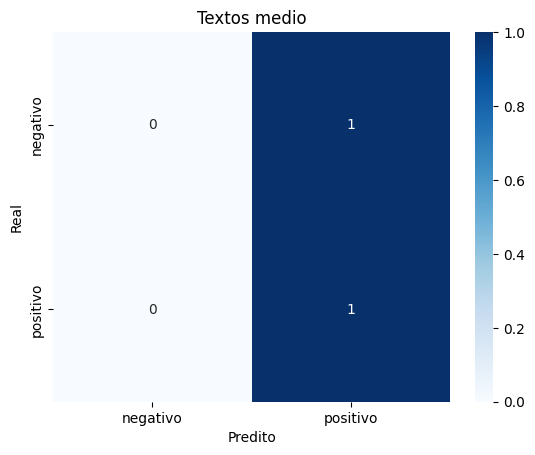

Matriz de confusão para textos curto
[[1 1]
 [0 4]]


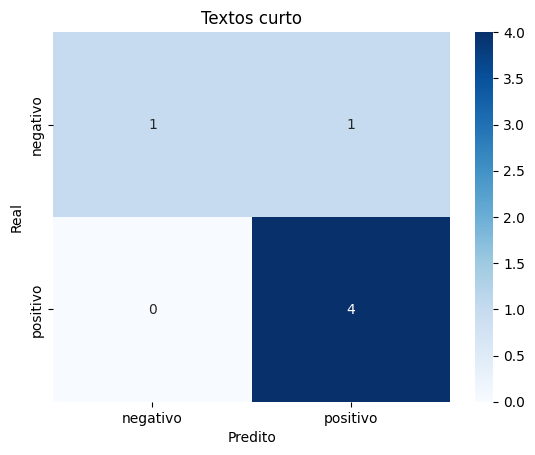

In [19]:
for category in df['len_category'].unique():
    subset = df[df['len_category'] == category]
    if not subset.empty:
        print(f"Matriz de confusão para textos {category}")
        print(confusion_matrix(subset['label'], subset["pred"]))
        sns.heatmap(confusion_matrix(subset['label'], subset["pred"]),
                    annot=True, fmt='d', cmap="Blues",
                    xticklabels=['negativo','positivo'],
                    yticklabels=['negativo', 'positivo'])
        
        plt.title(f"Textos {category}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()